# Modelado de topicos para la clusterizacion y predicciones de varietales

### Importamos las librerias y paquetes necesarios

Librerias

In [2]:
import pandas as pd
import numpy as np
import nltk

Paquetes especificos

In [3]:
from IPython.display import display_html
from nltk.corpus import stopwords

Para el caso que no tegamos la lista de stopWords, la podemos descargar con el siguiente comando

In [4]:
# nltk.download('stopwords')

********************************

### Seteamos algunas cosas y definimos funciones para mas adelante

Comenzamos con algunas cosas que vamos a necesitar mas adelante

In [5]:
# La creacion de la lista de stopsWords customizada se debe a que en cada topico existe un grupo de palabras que no 
# aportan informacion relevante para el analisis, en este caso, por ejemplo, la palabra wine, no tiene relevancia
# ya es un pablara que hace referencia al objeto de analisis direcamente sin destacar niguna propiedad del el
customStopWords = ['wine', 'flavors']

In [6]:
#Stop Words que incluyen por defecto la libreria NLTK
stopWords = stopwords.words('english') + customStopWords

In [7]:
# Esta funcion nos va a permitir mas adelante
# visualizar algunos DataFrames de manera simultanea
def mydisplay(dfs, names=[], index=False):

    count = 0
    maxTables = 6 
    
    if len(dfs) < maxTables:
        maxTables = len(dfs)
        
    
    if not names:
        names = [x for x in range(len(dfs))]

    html_str = ''
    html_th = ''
    html_td = ''
    
    # contruccion del esqueleto html para mostrar dataFrames simultaneamente
    # de esta manera se facilita la visualizacion para evaluar los datos y hacer comparaciones
    for df, name in zip(dfs, names):
        if count < (maxTables):
            html_th += (''.join(f'<th style="text-align:center">{name}</th>'))
            html_td += (''.join(f'<td style="vertical-align:top"> {df.to_html(index=index)}</td>'))
            # Este contador lo uso para cerrar las filas en un maximo de 6 columnas
            count += 1 
        else:
            #Cuando el contador llega a 6 se incluyen las columnas a la tabla
            html_str += f'<tr>{html_th}</tr><tr>{html_td}</tr>'
            # Se reinicia el string con el dato que esta en las variables del for, para no perderlo
            html_th = f'<th style="text-align:center">{name}</th>'
            html_td = f'<td style="vertical-align:top"> {df.to_html(index=False)}</td>'
            # Finalmente reinicio el contador
            count = 1
    
    # Este condicionl esta aca por que probablemente el for termine de recorrer los datos y el contador no quede
    # en cero, esto implica que la tabla html que estamos construyendo no quede apropiadamente cerrada
    # para prevenir esto, aca puse el condicional que va a cerrar el tag cuando el contador no sea cero
    # aclaroo que esta funcion tiene un bug, si lo econtras y/o lo arreglas escribime arzanico@hotmail.com
    html_str += f'<tr>{html_th}</tr><tr>{html_td}</tr>'
        
        
    
    html_str += f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)

***********

### Importamos el set de datos

Set de Datos

Los datos fueron tomados de sitio https://www.kaggle.com
Publicados en https://www.kaggle.com/zynicide/wine-reviews 


In [8]:
# df = pd.read_csv('../input/winemag-data-130k-v2.csv')
df = pd.read_csv('../data/winemag-data-130k-v2.csv', index_col = None)
df.drop(columns=['Unnamed: 0'], inplace = True)

### Realizamos las primeras transformaciones y comenzamos con el analisis exploratorio

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


Antes de realizar cualquier cambio, transformacion o evaluacion de los datos, incluso antes de empezar a explorar los datos, me gusta verificar la existencia de datos nulo o "missing data".

-Quiero ver en que columnas se encuentran

-Cuantos son

-Por que faltan 

-Que voy a hacer con ellos. Eliminar las filas o columnas, imputar los datos, etc


In [10]:
#Consultamos si hay algun missing data, verificacion, por columna de al menos uno.
pd.DataFrame(pd.isnull(df).any()).rename(columns={0:'Bool'}).reset_index(drop=False).Bool.any()

True

Como vemos que si hay "missing data" en al menos una columna podemos correr un for para ver en que columnas y cuantos realmente


In [11]:
mydisplay([pd.DataFrame(pd.isnull(df[c]).value_counts()) for c in df.columns], [c for c in df.columns], index=True)    

country description designation points price province 
 
 
 
 country 
 
 
 
 
 False 
 129908 
 
 
 True 
 63 
 
 
 
 
 
 
 description 
 
 
 
 
 False 
 129971 
 
 
 
 
 
 
 designation 
 
 
 
 
 False 
 92506 
 
 
 True 
 37465 
 
 
 
 
 
 
 points 
 
 
 
 
 False 
 129971 
 
 
 
 
 
 
 price 
 
 
 
 
 False 
 120975 
 
 
 True 
 8996 
 
 
 
 
 
 
 province 
 
 
 
 
 False 
 129908 
 
 
 True 
 63 
 
 
 region_1 region_2 taster_name taster_twitter_handle title variety 
 
 
 region_1 
 
 
 
 
 108724 
 
 
 21247 
 
 
 
 
 
 
 region_2 
 
 
 
 
 True 
 79460 
 
 
 False 
 50511 
 
 
 
 
 
 
 taster_name 
 
 
 
 
 False 
 103727 
 
 
 True 
 26244 
 
 
 
 
 
 
 taster_twitter_handle 
 
 
 
 
 False 
 98758 
 
 
 True 
 31213 
 
 
 
 
 
 
 title 
 
 
 
 
 False 
 129971 
 
 
 
 
 
 
 variety 
 
 
 
 
 False 
 129970 
 
 
 True 
 1 
 
 
 winery 
 
 
 winery 
 
 
 
 
 129971 
 
 
 country description designation points price province 
 
 
 
 country 
 
 
 
 
 False 
 129908 
 
 
 True 
 63 
 
 
 
 
 
 
 description 
 
 
 
 
 False 
 129971 
 
 
 
 
 
 
 designation 
 
 
 
 
 False 
 92506 
 
 
 True 
 37465 
 
 
 
 
 
 
 points 
 
 
 
 
 False 
 129971 
 
 
 
 
 
 
 price 
 
 
 
 
 False 
 120975 
 
 
 True 
 8996 
 
 
 
 
 
 
 province 
 
 
 
 
 False 
 129908 
 
 
 True 
 63 
 
 
 region_1 region_2 taster_name taster_twitter_handle title variety 
 
 
 region_1 
 
 
 
 
 108724 
 
 
 21247 
 
 
 
 
 
 
 region_2 
 
 
 
 
 True 
 79460 
 
 
 False 
 50511 
 
 
 
 
 
 
 taster_name 
 
 
 
 
 False 
 103727 
 
 
 True 
 26244 
 
 
 
 
 
 
 taster_twitter_handle 
 
 
 
 
 False 
 98758 
 
 
 True 
 31213 
 
 
 
 
 
 
 title 
 
 
 
 
 False 
 129971 
 
 
 
 
 
 
 variety 
 
 
 
 
 False 
 129970 
 
 
 True 
 1 
 
 
 winery 
 
 
 winery 
 
 
 
 
 129971

Vemos que la columna variety tiene un solo nan, por lo tanto lo mejor va a ser dropear esa fila.

In [12]:
#Pasamos algunos datos de texto a minuscula
df.description = df.description.apply(lambda x : x.lower())
df.dropna(how='any', inplace=True)
df.variety = df.variety.apply(lambda x : x.lower())

In [13]:
#Sample data of all columns
df.sample(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
110828,US,"this powerful blend of 23% malbec, 20% carmene...",Reconciliation,92,75.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Dubost 2010 Reconciliation Red (Paso Robles),red blend,Dubost


In [14]:
#Amount of uniques varieties
print('Se encuentrar ',df.variety.unique().size, ' variedades diferentes')
print('Hay vinos de ',df.country.unique().size, ' paises', end=' ')
print('y',df.winery.unique().size, ' bodegas diferentes')

Se encuentrar  183  variedades diferentes
Hay vinos de  1  paises y 2791  bodegas diferentes


Top 20 variatales mas revisados

In [15]:
top20Rw = pd.DataFrame(df.variety.value_counts()[:20]).reset_index(drop=False).rename(columns={'index':'varietal','variety':'recuento'})

In [16]:
top20Rw

,varietal,recuento
0,pinot noir,4788
1,chardonnay,2407
2,cabernet sauvignon,2372
3,red blend,1803
4,syrah,1678
5,zinfandel,1114
6,bordeaux-style red blend,1112
7,merlot,597
8,sauvignon blanc,574
9,rhône-style red blend,516


DE AQUI EN ADELANTE VAMOS A MENTERNOS UN POCO MAS EN LOS DATOS PARA VER COMO SE COMPORTAN

RECORDEMOS QUE NUESTRO FOCO DE ANALISIS ES EL TEXTO

EL OBJETIVO ES CLUSTERISAR VARIEDADES Y LUEGO CREAR LAS CLASES PARA PREDECIR VARIEDAD A PARTIR DE DESCRIPCION

##### Revision de los nombres de las variedades de los vinos

In [17]:
#Aqui quitamos las stopsWords
desc = df[['description', 'variety']].copy()
desc.description =  desc.description.apply(lambda x : ' '.join([w for w in x.split() if w.lower() not in stopWords]))

In [18]:
print('Numero medio de palabras con las que se describen los varietales')
round(desc.description.apply(lambda x : len(x.split())).mean(), 2)

Numero medio de palabras con las que se describen los varietales


26.22

Vamos a evaluar un varietal, Pinot Noir. Vamos a tomar todas las descripciones y hacer un lista de las palabras que se usaron


-> Acordate que pasamos todo a minuscula

In [19]:
pinotNoir = pd.Series((' '.join([x for x in desc.groupby('variety').get_group('pinot noir').description]).split()))

In [20]:
print('Evaluacion de las descripciones del varital Pinot Noir')
print('Cantidad de palabras distintas usadas :', pinotNoir.unique().size)
print('Aparicion promedio de palabras : ', round(pinotNoir.value_counts().mean(), 2))
print('Lista ordenada de las palabras usadas (top 5):')
pinotNoir.value_counts()[:5]

Evaluacion de las descripciones del varital Pinot Noir
Cantidad de palabras distintas usadas : 13130
Aparicion promedio de palabras :  9.89
Lista ordenada de las palabras usadas (top 5):


fruit      1513
cherry     1465
black      1421
red         795
finish.     786
dtype: int64

#### Teniendo en cuanta lo anterior vamos a entrar en un analisis de palabras. Vamos a ver como las palabra describen a un varietal y cuan comun o especifica es cada palabra a la hora de describir un varietal. Recordemos que estas manipulaciones de texto tienen el obeto de reducir el ruido en el analisis de clustering que haremos mas adelante

In [21]:
#Palabras econtradas en los varietales
df1 = pd.DataFrame(pd.Series(' '.join([w for w in desc.variety]).split()).value_counts()).reset_index(drop=False).rename(columns={'index':'words',0:'recuento'})

Comparacion de los varietales mas revisados contra las palabras mas usadas en los nombres de los varietales

In [22]:
mydisplay([top20Rw,df1[:20],df1[20:40],df1[40:60],df1[60:80],df1[80:101]], index=True)

0 1 2 3 4 5 
 
 
 
 varietal 
 recuento 
 
 
 
 
 0 
 pinot noir 
 4788 
 
 
 1 
 chardonnay 
 2407 
 
 
 2 
 cabernet sauvignon 
 2372 
 
 
 3 
 red blend 
 1803 
 
 
 4 
 syrah 
 1678 
 
 
 5 
 zinfandel 
 1114 
 
 
 6 
 bordeaux-style red blend 
 1112 
 
 
 7 
 merlot 
 597 
 
 
 8 
 sauvignon blanc 
 574 
 
 
 9 
 rhône-style red blend 
 516 
 
 
 10 
 riesling 
 511 
 
 
 11 
 rosé 
 369 
 
 
 12 
 white blend 
 334 
 
 
 13 
 sparkling blend 
 299 
 
 
 14 
 cabernet franc 
 284 
 
 
 15 
 malbec 
 282 
 
 
 16 
 grenache 
 273 
 
 
 17 
 pinot gris 
 269 
 
 
 18 
 viognier 
 265 
 
 
 19 
 petite sirah 
 251 
 
 
 
 
 
 
 words 
 recuento 
 
 
 
 
 0 
 pinot 
 5173 
 
 
 1 
 noir 
 4801 
 
 
 2 
 blend 
 4274 
 
 
 3 
 red 
 3431 
 
 
 4 
 sauvignon 
 3006 
 
 
 5 
 cabernet 
 2749 
 
 
 6 
 chardonnay 
 2407 
 
 
 7 
 syrah 
 1678 
 
 
 8 
 bordeaux-style 
 1138 
 
 
 9 
 zinfandel 
 1114 
 
 
 10 
 blanc 
 781 
 
 
 11 
 rhône-style 
 670 
 
 
 12 
 merlot 
 600 
 
 
 13 
 white 
 516 
 
 
 14 
 riesling 
 514 
 
 
 15 
 rosé 
 369 
 
 
 16 
 grenache 
 329 
 
 
 17 
 sparkling 
 299 
 
 
 18 
 franc 
 293 
 
 
 19 
 malbec 
 282 
 
 
 
 
 
 
 words 
 recuento 
 
 
 
 
 20 
 gris 
 269 
 
 
 21 
 viognier 
 265 
 
 
 22 
 sirah 
 258 
 
 
 23 
 petite 
 256 
 
 
 24 
 sangiovese 
 171 
 
 
 25 
 tempranillo 
 158 
 
 
 26 
 mourvèdre 
 117 
 
 
 27 
 barbera 
 105 
 
 
 28 
 gewürztraminer 
 99 
 
 
 29 
 verdot 
 89 
 
 
 30 
 petit 
 83 
 
 
 31 
 g-s-m 
 80 
 
 
 32 
 meritage 
 67 
 
 
 33 
 chenin 
 57 
 
 
 34 
 roussanne 
 54 
 
 
 35 
 grigio 
 52 
 
 
 36 
 veltliner 
 46 
 
 
 37 
 grüner 
 46 
 
 
 38 
 albariño 
 45 
 
 
 39 
 primitivo 
 42 
 
 
 
 
 
 
 words 
 recuento 
 
 
 
 
 40 
 muscat 
 41 
 
 
 41 
 sauvignon-syrah 
 38 
 
 
 42 
 sémillon 
 35 
 
 
 43 
 moscato 
 32 
 
 
 44 
 carmenère 
 28 
 
 
 45 
 nebbiolo 
 26 
 
 
 46 
 port 
 25 
 
 
 47 
 blanc-semillon 
 24 
 
 
 48 
 syrah-cabernet 
 24 
 
 
 49 
 cinsault 
 24 
 
 
 50 
 tannat 
 23 
 
 
 51 
 syrah-grenache 
 22 
 
 
 52 
 marsanne 
 20 
 
 
 53 
 sauvignon-merlot 
 18 
 
 
 54 
 merlot-cabernet 
 18 
 
 
 55 
 grenache-syrah 
 17 
 
 
 56 
 semillon-sauvignon 
 16 
 
 
 57 
 fumé 
 14 
 
 
 58 
 carignane 
 12 
 
 
 59 
 gamay 
 12 
 
 
 
 
 
 
 words 
 recuento 
 
 
 
 
 60 
 vermentino 
 12 
 
 
 61 
 dolcetto 
 12 
 
 
 62 
 verdelho 
 11 
 
 
 63 
 canelli 
 10 
 
 
 64 
 champagne 
 10 
 
 
 65 
 franc-merlot 
 9 
 
 
 66 
 colombard 
 9 
 
 
 67 
 touriga 
 9 
 
 
 68 
 nacional 
 9 
 
 
 69 
 teroldego 
 8 
 
 
 70 
 claret 
 8 
 
 
 71 
 charbono 
 8 
 
 
 72 
 graciano 
 8 
 
 
 73 
 shiraz 
 7 
 
 
 74 
 mission 
 7 
 
 
 75 
 syrah-mourvèdre 
 7 
 
 
 76 
 syrah-petite 
 7 
 
 
 77 
 roussanne-viognier 
 6 
 
 
 78 
 counoise 
 6 
 
 
 79 
 auxerrois 
 6 
 
 
 
 
 
 
 words 
 recuento 
 
 
 
 
 80 
 blaufränkisch 
 6 
 
 
 81 
 pinot-chardonnay 
 5 
 
 
 82 
 lemberger 
 5 
 
 
 83 
 sauvignon-cabernet 
 5 
 
 
 84 
 vidal 
 5 
 
 
 85 
 orange 
 5 
 
 
 86 
 sagrantino 
 4 
 
 
 87 
 garnacha 
 4 
 
 
 88 
 zweigelt 
 4 
 
 
 89 
 bouschet 
 4 
 
 
 90 
 sauvignon-sangiovese 
 4 
 
 
 91 
 torrontés 
 4 
 
 
 92 
 alicante 
 4 
 
 
 93 
 bianca 
 4 
 
 
 94 
 picpoul 
 4 
 
 
 95 
 viognier-roussanne 
 4 
 
 
 96 
 malvasia 
 4 
 
 
 97 
 ugni 
 3 
 
 
 98 
 chardonnay-semillon 
 3 
 
 
 99 
 black 
 3 
 
 
 100 
 valdiguié 
 3 
 
 
 0 1 2 3 4 5 
 
 
 
 varietal 
 recuento 
 
 
 
 
 0 
 pinot noir 
 4788 
 
 
 1 
 chardonnay 
 2407 
 
 
 2 
 cabernet sauvignon 
 2372 
 
 
 3 
 red blend 
 1803 
 
 
 4 
 syrah 
 1678 
 
 
 5 
 zinfandel 
 1114 
 
 
 6 
 bordeaux-style red blend 
 1112 
 
 
 7 
 merlot 
 597 
 
 
 8 
 sauvignon blanc 
 574 
 
 
 9 
 rhône-style red blend 
 516 
 
 
 10 
 riesling 
 511 
 
 
 11 
 rosé 
 369 
 
 
 12 
 white blend 
 334 
 
 
 13 
 sparkling blend 
 299 
 
 
 14 
 cabernet franc 
 284 
 
 
 15 
 malbec 
 282 
 
 
 16 
 grenache 
 273 
 
 
 17 
 pinot gris 
 269 
 
 
 18 
 viognier 
 265 


In [23]:
#Varietales que contienen las palabras mas usadas
dfs = list()
for w in df1.words:
    word = w
    data = pd.DataFrame(pd.Series([x for x in desc.variety if w in x]).value_counts()).reset_index(drop=False).rename(columns={'index':'word {}'.format(w),0:'recuento'})
    
    dfs.append((data,word))

In [24]:
#Varietals that contains the most common words. Aca la funcion de visualizacion
mydisplay([d[0] for d in dfs])#, [w[1] for w in dfs])

0 1 2 3 4 5 
 
 
 word pinot 
 recuento 
 
 
 
 
 pinot noir 
 4788 
 
 
 pinot gris 
 269 
 
 
 pinot blanc 
 57 
 
 
 pinot grigio 
 52 
 
 
 pinot-chardonnay 
 5 
 
 
 pinotage 
 2 
 
 
 pinot meunier 
 2 
 
 
 pinot noir-syrah 
 2 
 
 
 pinot blanc-pinot noir 
 1 
 
 
 pinot auxerrois 
 1 
 
 
 pinot gris-gewürztraminer 
 1 
 
 
 chardonnay-pinot blanc 
 1 
 
 
 
 
 
 word noir 
 recuento 
 
 
 
 
 pinot noir 
 4788 
 
 
 gamay noir 
 9 
 
 
 pinot noir-syrah 
 2 
 
 
 grenache noir 
 2 
 
 
 baco noir 
 1 
 
 
 pinot blanc-pinot noir 
 1 
 
 
 
 
 
 word blend 
 recuento 
 
 
 
 
 red blend 
 1803 
 
 
 bordeaux-style red blend 
 1112 
 
 
 rhône-style red blend 
 516 
 
 
 white blend 
 334 
 
 
 sparkling blend 
 299 
 
 
 rhône-style white blend 
 154 
 
 
 bordeaux-style white blend 
 26 
 
 
 cabernet blend 
 11 
 
 
 champagne blend 
 10 
 
 
 tempranillo blend 
 5 
 
 
 grenache blend 
 3 
 
 
 touriga nacional blend 
 1 
 
 
 
 
 
 word red 
 recuento 
 
 
 
 
 red blend 
 1803 
 
 
 bordeaux-style red blend 
 1112 
 
 
 rhône-style red blend 
 516 
 
 
 
 
 
 word sauvignon 
 recuento 
 
 
 
 
 cabernet sauvignon 
 2372 
 
 
 sauvignon blanc 
 574 
 
 
 cabernet sauvignon-syrah 
 38 
 
 
 sauvignon blanc-semillon 
 24 
 
 
 syrah-cabernet sauvignon 
 21 
 
 
 cabernet sauvignon-merlot 
 18 
 
 
 semillon-sauvignon blanc 
 16 
 
 
 merlot-cabernet sauvignon 
 9 
 
 
 cabernet sauvignon-cabernet franc 
 5 
 
 
 cabernet sauvignon-sangiovese 
 4 
 
 
 sangiovese-cabernet sauvignon 
 3 
 
 
 tempranillo-cabernet sauvignon 
 2 
 
 
 malbec-cabernet sauvignon 
 1 
 
 
 cabernet sauvignon-malbec 
 1 
 
 
 
 
 
 word cabernet 
 recuento 
 
 
 
 
 cabernet sauvignon 
 2372 
 
 
 cabernet franc 
 284 
 
 
 cabernet sauvignon-syrah 
 38 
 
 
 syrah-cabernet sauvignon 
 21 
 
 
 cabernet sauvignon-merlot 
 18 
 
 
 cabernet blend 
 11 
 
 
 merlot-cabernet sauvignon 
 9 
 
 
 cabernet franc-merlot 
 9 
 
 
 merlot-cabernet 
 5 
 
 
 cabernet sauvignon-cabernet franc 
 5 
 
 
 merlot-cabernet franc 
 4 
 
 
 sangiovese cabernet 
 4 
 
 
 cabernet sauvignon-sangiovese 
 4 
 
 
 cabernet-syrah 
 3 
 
 
 syrah-cabernet 
 3 
 
 
 cabernet merlot 
 3 
 
 
 sangiovese-cabernet sauvignon 
 3 
 
 
 tempranillo-cabernet sauvignon 
 2 
 
 
 cabernet sauvignon-malbec 
 1 
 
 
 malbec-cabernet sauvignon 
 1 
 
 
 6 7 8 9 10 11 
 
 
 word chardonnay 
 recuento 
 
 
 
 
 chardonnay 
 2407 
 
 
 pinot-chardonnay 
 5 
 
 
 chardonnay-semillon 
 3 
 
 
 chardonnay-viognier 
 3 
 
 
 viognier-chardonnay 
 2 
 
 
 semillon-chardonnay 
 1 
 
 
 chardonnay-pinot blanc 
 1 
 
 
 
 
 
 word syrah 
 recuento 
 
 
 
 
 syrah 
 1678 
 
 
 cabernet sauvignon-syrah 
 38 
 
 
 syrah-grenache 
 22 
 
 
 syrah-cabernet sauvignon 
 21 
 
 
 grenache-syrah 
 17 
 
 
 syrah-mourvèdre 
 7 
 
 
 syrah-petite sirah 
 7 
 
 
 syrah-viognier 
 3 
 
 
 sangiovese-syrah 
 3 
 
 
 cabernet-syrah 
 3 
 
 
 syrah-cabernet 
 3 
 
 
 pinot noir-syrah 
 2 
 
 
 syrah-tempranillo 
 2 
 
 
 mourvèdre-syrah 
 1 
 
 
 syrah-merlot 
 1 
 
 
 tempranillo-syrah 
 1 
 
 
 syrah-petit verdot 
 1 
 
 
 syrah-grenache-viognier 
 1 
 
 
 tannat-syrah 
 1 
 
 
 
 
 
 word bordeaux-style 
 recuento 
 
 
 
 
 bordeaux-style red blend 
 1112 
 
 
 bordeaux-style white blend 
 26 
 
 
 
 
 
 word zinfandel 
 recuento 
 
 
 
 
 zinfandel 
 1114 
 
 
 
 
 
 word blanc 
 recuento 
 
 
 
 
 sauvignon blanc 
 574 
 
 
 chenin blanc 
 57 
 
 
 pinot blanc 
 57 
 
 
 grenache blanc 
 51 
 
 
 sauvignon blanc-semillon 
 24 
 
 
 semillon-sauvignon blanc 
 16 
 
 
 fumé blanc 
 14 
 
 
 vidal blanc 
 5 
 
 
 ugni blanc 
 3 
 
 
 muscat blanc 
 2 
 
 
 muscat blanc à petits grains 
 1 
 
 
 garnacha blanca 
 1 
 
 
 chardonnay-pinot blanc 
 1 
 
 
 pinot blanc-pinot noir 
 1 
 
 
 
 
 
 word rhône-style 
 recuento 
 
 
 
 
 rhône-style red blend 
 516 
 
 
 rhône-style white blend 
 154 
 
 
 12 13 14 15 16 17 
 
 
 word merlot 
 recuento 
 
 
 
 
 merlot 
 597 
 
 
 cabernet sauvignon-merlot 
 18 

Esto por ahora...Ultima actualizacion 17/01/2020

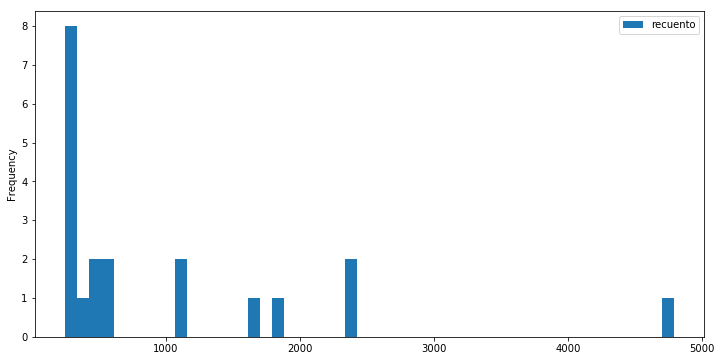

In [25]:
top20Rw.plot(kind='hist', bins=50, figsize=(12,6));

### Voy a repetir el analisis que hice antes en las palabras de la columna de varietales, pero con la descripcion.

Recodemos que ya se quitaron las stopsWords mas arriba

In [29]:
# El siguiente analisis se va a enfocar en las descripciones de los varitales.
df2 = pd.DataFrame(pd.Series(' '.join([w for w in desc.description]).split()).value_counts()).reset_index(drop=False).rename(columns={'index':'words',0:'recuento'})

In [32]:
print('Numero medio de palabras con las que se describen los varietales')
round(desc.description.apply(lambda x : len(x.split())).mean(), 2)

Numero medio de palabras con las que se describen los varietales


26.22

In [35]:
print('Cantidad de palabras distintas usadas :', df2.words.unique().size)
print('Aparicion promedio de palabras : ', round(df2.words.value_counts().mean(), 2))
print('Lista ordenada de las palabras usadas (top 5):')
df2[:5]

Cantidad de palabras distintas usadas : 29093
Aparicion promedio de palabras :  1.0
Lista ordenada de las palabras usadas (top 5):


,words,recuento
0,fruit,6623
1,aromas,5651
2,black,5535
3,cherry,3886
4,finish.,3706


Tengo palabras que se encunetran en una sola variedad.
	- Estas palabras describen unicamente un varietal

Otras palabras se encuentran en dos o mas varietales
	- Las palrabras describen una propiedad comun entre varietasles, o describen una familia de varitales. (*indetificar cuando describen familias o caracteristicas)

Algunas palabras son muy comunes en las descriptciones.
	-Estas palabras pueden describir un ingrediente agregado a algunos vinos, ej frutas, hierbas
	-Estas palabras no nos indican el varietal

Tambien podemos encontrar palabras que hacen referencia al proceso de fabricacion.
 	-Estas palabras pueden aparecer junto con el varietal, o con la designacion, quiza con el precio
	-Tienen que tener una logica con otro dato, por ejemplo barricas de roble con tiempo de estacionamiento
